In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import cross_val_score , RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import mlflow
from mlflow.tracking import MlflowClient

import pickle

import warnings
warnings.filterwarnings("ignore")


In [60]:
df = pd.read_pickle("../data/interim/04_data_features.pkl")

In [61]:
# Remove non-feature columns from the DataFrame to create the training set
# "participant", "category", "set", and "duration" 
# are dropped as they are not considered features
df_train = df.drop(["participant","category","set","duration"],axis = 1)

# Separate features (X) and labels (y) from the training set
X = df_train.drop("label",axis = 1) # Features
y = df_train["label"] # Target

# Split the data into training and test sets using stratified sampling to maintain class proportions
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

# Define different subsets of features based on their characteristics
# These subsets depend on the feature engineering performed earlier
basic_features = ["acc_x","acc_y","acc_z","gyr_x","gyr_y","gyr_z"]
sqaured_features = ["acc_r","gyr_r"]
pca_features = ["pca_1","pca_2","pca_3"]
time_features = [f for f in df_train.columns if "_temp" in f]
freq_features = [f for f in df_train.columns if ("_freq" in f) or ("_pse" in f)]
cluster_features = ["cluster_label"]


# Define different combinations of feature subsets
# These combinations are based on the feature engineering results
feature_1 = list(set(basic_features))  # Features from basic sensor readings only
feature_2 = list(set(basic_features + sqaured_features + pca_features))  # Additional derived and transformed features
feature_3 = list(set(feature_2 + time_features))  # Includes time-domain features
feature_4 = list(set(feature_3 + freq_features + cluster_features))  # Includes frequency-domain and cluster-based features

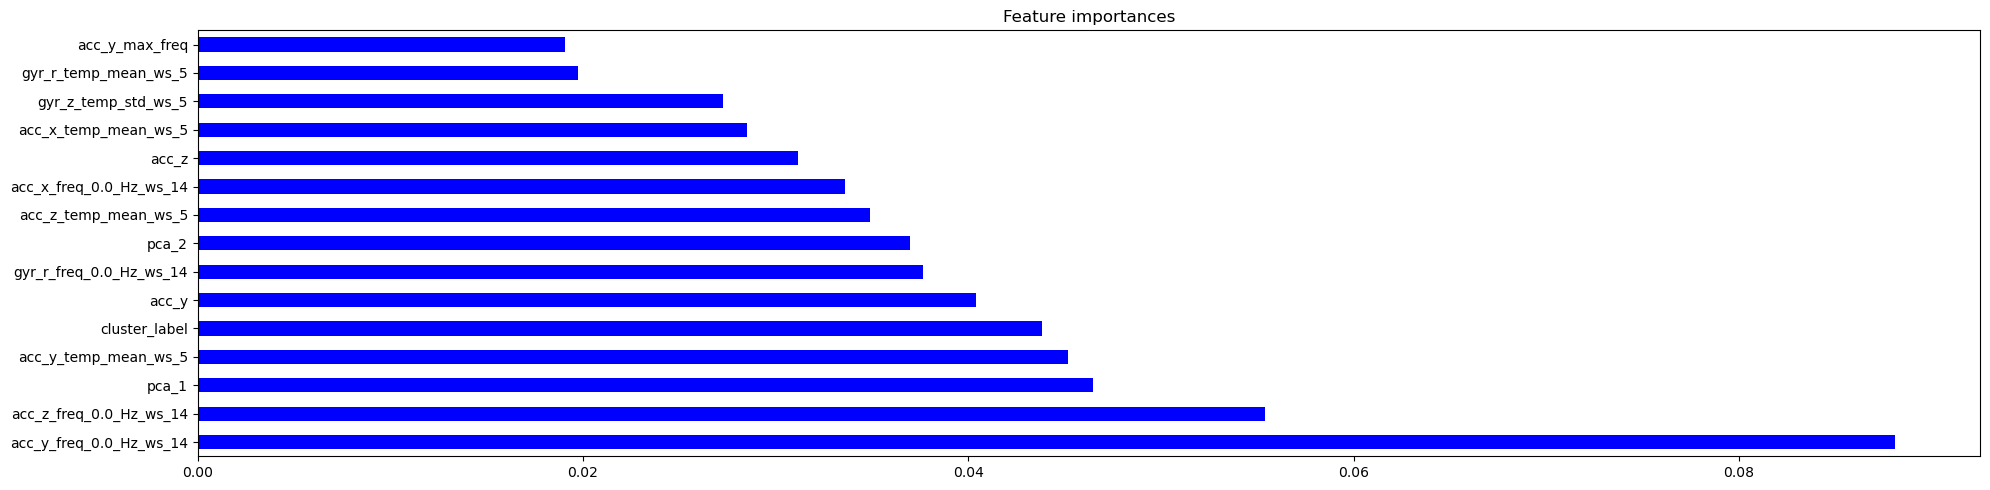

In [62]:
ex=ExtraTreesClassifier()
ex.fit(X,y)
ex.feature_importances_
feat=pd.Series(ex.feature_importances_,index=X.columns)

plt.figure(figsize=(20,5))
plt.title('Feature importances')
feat=pd.Series(ex.feature_importances_,index=X.columns)
feat.nlargest(15).plot(kind='barh', color="b", align="center")
plt.tight_layout()
plt.grid(False)
plt.show()

In [63]:
selected_features = feat.nlargest(15).index
selected_features = list(selected_features)
selected_features

['acc_y_freq_0.0_Hz_ws_14',
 'acc_z_freq_0.0_Hz_ws_14',
 'pca_1',
 'acc_y_temp_mean_ws_5',
 'cluster_label',
 'acc_y',
 'gyr_r_freq_0.0_Hz_ws_14',
 'pca_2',
 'acc_z_temp_mean_ws_5',
 'acc_x_freq_0.0_Hz_ws_14',
 'acc_z',
 'acc_x_temp_mean_ws_5',
 'gyr_z_temp_std_ws_5',
 'gyr_r_temp_mean_ws_5',
 'acc_y_max_freq']

# Modeling

---


### initialization mlflow


In [64]:
EXPERIMENT_NAME = "Baseline Model"
EXPERIMENT_MODEL_PATH = "Baseline_Model.pkl"

### 0)Baseline model


In [65]:
## Create a baseline model "Logistic Regression" using only the basic features 
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train[basic_features],y_train)

LogisticRegression()

In [66]:
logistic_reg_pred = logistic_reg.predict(X_test[basic_features])

In [67]:
# Evaluate the model
accuracy = accuracy_score(y_test, logistic_reg_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7466390899689762


In [68]:
with open ("../models/01_"+EXPERIMENT_MODEL_PATH, 'wb') as f:
    pickle.dump(logistic_reg, f)

Tracking with mlflow

In [69]:
# Initialize the MLflow client
client = MlflowClient()


In [70]:
# Initialization
mlflow.set_experiment(EXPERIMENT_NAME)
exp = client.get_experiment_by_name(EXPERIMENT_NAME)

2024/03/23 22:05:07 INFO mlflow.tracking.fluent: Experiment with name 'Baseline Model' does not exist. Creating a new experiment.


In [71]:
with mlflow.start_run(experiment_id=exp.experiment_id):
    ## Log the parameters and metrics
    mlflow.log_param("features", "basic")
    mlflow.log_metric("accuracy", accuracy)
    
    ## Log the model
    mlflow.log_artifact("../models/01_"+EXPERIMENT_MODEL_PATH)

In [72]:
mlflow.search_runs(experiment_ids=exp.experiment_id)
## mlflow.get_tracking_uri()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.features,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
0,c8e9e4470cf74316bd45f696b5cb06ba,415387670719915279,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 20:05:10.303000+00:00,2024-03-23 20:05:10.394000+00:00,0.746639,basic,melodic-dolphin-283,HP,LOCAL,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...


### 1)choose model


In [17]:
# Define dictionary of models
models = {'Logistic Regression': LogisticRegression(),
          'Decision Tree': DecisionTreeClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Gradient Boosting Classifier': GradientBoostingClassifier(),
          'Support Vector Machine': SVC(),
          'Stochastic Gradient Descent': SGDClassifier(),
          'Naive Bayes': GaussianNB()}

### 2)Train the model


In [18]:
def fit_score(models, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = cross_val_score(model,
                                             X_test,
                                             y_test,
                                             scoring='accuracy',
                                             cv=3
                                             ).mean()

    return model_scores


### 3)Evaluate the model


In [19]:

# Definedictionary of features_set
feature_sets = {'feature_1': feature_1,
                'feature_2': feature_2,
                'feature_3': feature_3,
                'feature_4': feature_4,
                'selected_features': selected_features}
i= 0

for feature_set_name, features in feature_sets.items():
    X_train_features = X_train[features]
    X_test_features = X_test[features]
    
    model_scores = fit_score(models, X_train_features, X_test_features, y_train, y_test)
    print(f"Results for {feature_set_name}:")
    for model, score in model_scores.items():
        """
        EXPERIMENT_NAME = model
        EXPERIMENT_MODEL_PATH = model +".pkl"
        
        # Initialization
        mlflow.set_experiment(EXPERIMENT_NAME)
        exp = client.get_experiment_by_name(EXPERIMENT_NAME)
        
        i+=1
        with open ("../models/"+str(i)+"_"+EXPERIMENT_MODEL_PATH, 'wb') as f:
            pickle.dump(model, f)
            
        with mlflow.start_run(experiment_id=exp.experiment_id):
            ## Log the parameters and metrics
            mlflow.log_param("features", feature_set_name)
            mlflow.log_metric("accuracy", score)
            
            ## Log the model
            mlflow.log_artifact("../models/"+str(i)+"_"+EXPERIMENT_MODEL_PATH)
    
    """
        print(f"{model}: {score}")
    print("\n")

Results for feature_1:
Logistic Regression: 0.7073566268612709
Decision Tree: 0.8479831291784449
Random Forest: 0.9131460364466153
Gradient Boosting Classifier: 0.89762770096597
Support Vector Machine: 0.556390977443609
Stochastic Gradient Descent: 0.5098904550378504
Naive Bayes: 0.8355896134197387


Results for feature_2:
Logistic Regression: 0.7466908960380492
Decision Tree: 0.8428167605715055
Random Forest: 0.904890102494087
Gradient Boosting Classifier: 0.8997012992840157
Support Vector Machine: 0.5491317808587967
Stochastic Gradient Descent: 0.5088135940875206
Naive Bayes: 0.8531751373318205


Results for feature_3:
Logistic Regression: 0.8883077258363299
Decision Tree: 0.8997045042273202
Random Forest: 0.9565858379965259
Gradient Boosting Classifier: 0.9503906825888251
Support Vector Machine: 0.752863616842618
Stochastic Gradient Descent: 0.7197950118262407
Naive Bayes: 0.9369619701427482


Results for feature_4:
Logistic Regression: 0.8655558333173087
Decision Tree: 0.9482882397

### 4)hyperparameter tuning


#RF of features set 4

In [20]:
param_grid = {
    'n_estimators': [50, 200, 400],
    'max_depth': [3, 10,None],
    'max_features': ['auto', 'sqrt', 'log2']
}


RF_4f = RandomizedSearchCV(estimator=RandomForestClassifier(),
                           param_distributions=param_grid,
                           n_iter=100,
                           scoring='accuracy',
                           cv=3,
                           verbose=1,
                           random_state=42,
                           n_jobs=-1)

RF_4f.fit(X_train[feature_4], y_train)

RF_4f.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


{'n_estimators': 400, 'max_features': 'sqrt', 'max_depth': None}

In [21]:
RF_4f.best_score_

0.9937952430196484

In [22]:
model_RF_4f = RandomForestClassifier(n_estimators= 200, max_features= 'sqrt', max_depth= None)
model_RF_4f.fit(X_train[feature_4], y_train)
y_pred_4f = model_RF_4f.predict(X_test[feature_4])


In [23]:
accuracy_F4 = accuracy_score(y_test, y_pred_4f)
accuracy_F4

0.9948293691830403

In [73]:

EXPERIMENT_NAME = "RF_F4_Model"
EXPERIMENT_MODEL_PATH = "RF_F4_Model.pkl"

with open ("../models/02_"+EXPERIMENT_MODEL_PATH, 'wb') as f:
    pickle.dump(model_RF_4f, f)

# Initialization

mlflow.set_experiment(EXPERIMENT_NAME)
exp1 = client.get_experiment_by_name(EXPERIMENT_NAME)
with mlflow.start_run(experiment_id=exp1.experiment_id):
    ## Log the parameters and metrics
    mlflow.log_param("features", "feature_4")
    mlflow.log_metric("accuracy", accuracy_F4)
    
    ## Log the model
    mlflow.log_artifact("../models/02_"+EXPERIMENT_MODEL_PATH)

2024/03/23 22:05:33 INFO mlflow.tracking.fluent: Experiment with name 'RF_F4_Model' does not exist. Creating a new experiment.


In [74]:
    
mlflow.search_runs(experiment_ids=exp1.experiment_id)
## mlflow.get_tracking_uri()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.features,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
0,0e9f1a8609cc484d84ca863a1821d5d2,237297857053471270,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 20:05:34.007000+00:00,2024-03-23 20:05:34.157000+00:00,0.994829,feature_4,honorable-worm-732,HP,LOCAL,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...


#RF for selected_features

In [26]:
param_grid = {
    'n_estimators': [50, 200,400],
    'max_depth': [3, 10,None],
    'max_features': ['auto', 'sqrt', 'log2']
}


RF_sf = RandomizedSearchCV(estimator=RandomForestClassifier(),
                           param_distributions=param_grid,
                           n_iter=100,
                           scoring='accuracy',
                           cv=3,
                           verbose=1,
                           random_state=42,
                           n_jobs=-1)

RF_sf.fit(X_train[selected_features], y_train)

RF_sf.best_params_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


{'n_estimators': 200, 'max_features': 'log2', 'max_depth': None}

In [27]:
RF_sf.best_score_

0.9869010685970355

In [28]:
model_RF_sf = RandomForestClassifier(n_estimators= 200, max_features= 'log2', max_depth= 10)
model_RF_sf.fit(X_train[selected_features], y_train)
y_pred_sf = RF_sf.predict(X_test[selected_features])


In [29]:
accuracy_sf = accuracy_score(y_test, y_pred_sf)
accuracy_sf

0.9917269906928645

In [77]:

EXPERIMENT_NAME = "RF_SF_Model"
EXPERIMENT_MODEL_PATH = "RF_SF_Model.pkl"

with open ("../models/03_"+EXPERIMENT_MODEL_PATH, 'wb') as f:
    pickle.dump(model_RF_sf, f)

# Initialization

mlflow.set_experiment(EXPERIMENT_NAME)
exp2 = client.get_experiment_by_name(EXPERIMENT_NAME)
with mlflow.start_run(experiment_id=exp2.experiment_id):
    ## Log the parameters and metrics
    mlflow.log_param("features", "selected_features")
    mlflow.log_metric("accuracy", accuracy_sf)
    
    ## Log the model
    mlflow.log_artifact("../models/03_"+EXPERIMENT_MODEL_PATH)

In [79]:
    
mlflow.search_runs(experiment_ids=exp2.experiment_id)
## mlflow.get_tracking_uri()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.features,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
0,0d3b69068086472a8d3ee38ba15fb453,828910791919044872,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 20:06:26.235000+00:00,2024-03-23 20:06:26.348000+00:00,0.991727,selected_features,calm-mare-793,HP,LOCAL,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...
1,dfb79349e5fe40f5a299c45eed6b6c17,828910791919044872,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 20:06:16.001000+00:00,2024-03-23 20:06:16.147000+00:00,0.991727,selected_features,loud-eel-153,HP,LOCAL,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...


### 5) final evaluation


In [32]:
model = RandomForestClassifier(n_estimators= 200, max_features= 'sqrt', max_depth= None)
model.fit(X_train[selected_features], y_train)
y_pred = model.predict(X_test[selected_features])


In [33]:
acc = accuracy_score(y_test, y_pred)
acc

0.9948293691830403

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       bench       0.99      0.99      0.99       175
        dead       0.99      0.99      0.99       172
         ohp       0.99      0.99      0.99       175
        rest       1.00      1.00      1.00       128
         row       0.99      0.99      0.99       142
       squat       1.00      1.00      1.00       175

    accuracy                           0.99       967
   macro avg       1.00      1.00      1.00       967
weighted avg       0.99      0.99      0.99       967



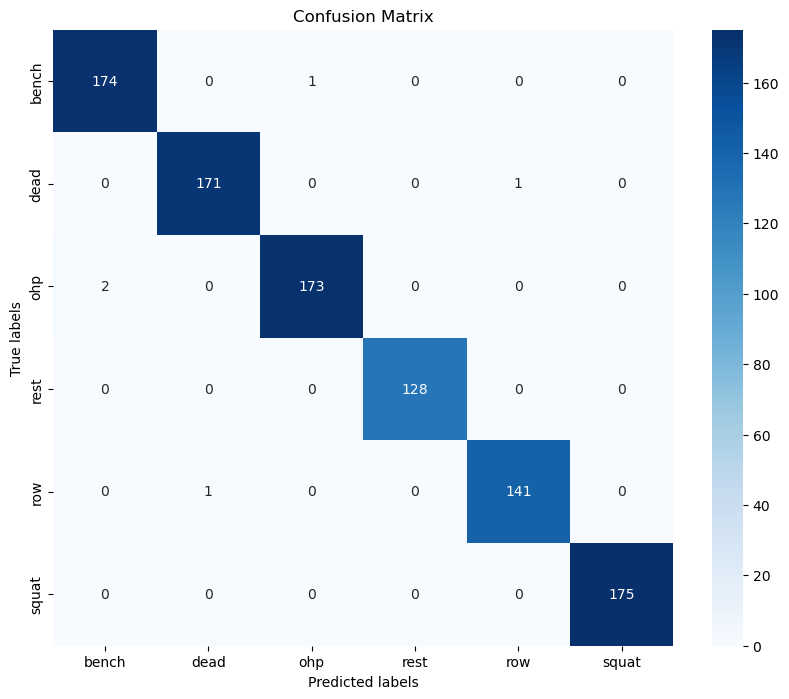

In [35]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



### 6)Interpretation of model parameters


Feature Importances:
acc_y_temp_mean_ws_5: 0.08032480849718761
acc_y_freq_0.0_Hz_ws_14: 0.11443275540080675
cluster_label: 0.02406845076345276
acc_z_freq_0.0_Hz_ws_14: 0.10040634783853424
pca_1: 0.061384800696201634
gyr_r_freq_0.0_Hz_ws_14: 0.09838747596347491
acc_y: 0.05725515699685842
acc_x_freq_0.0_Hz_ws_14: 0.08626053762066728
acc_z_temp_mean_ws_5: 0.061686021267169794
acc_z: 0.041086423652769606
acc_x_temp_mean_ws_5: 0.06354429968794455
gyr_z_temp_std_ws_5: 0.08436754970429615
pca_2: 0.04936267465617702
acc_z_pse: 0.02349812317317495
gyr_r_temp_mean_ws_5: 0.0539345740812844


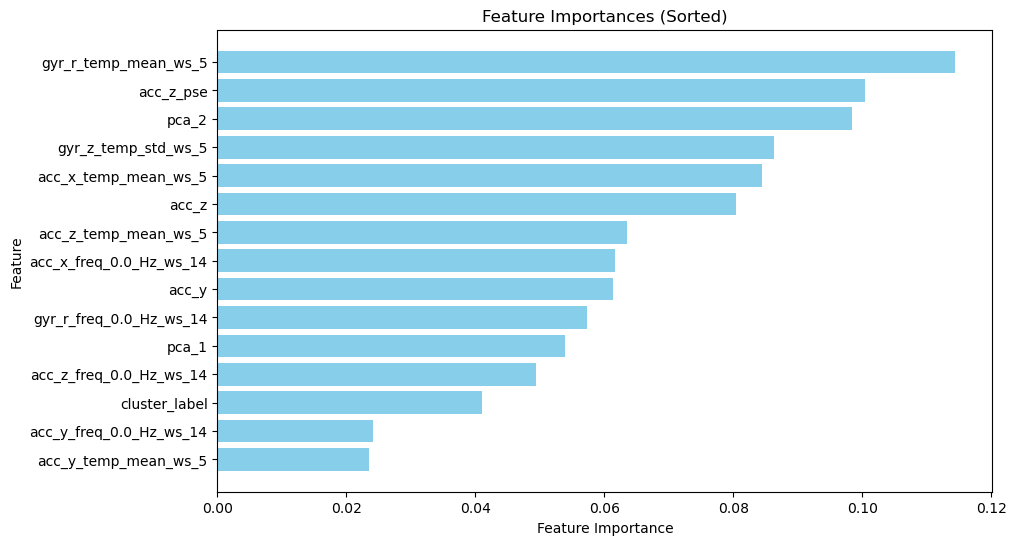

In [42]:

# Get feature importances
importances = model.feature_importances_

# Display the feature importances
print("Feature Importances:")
for feature, importance in zip(selected_features, importances):
    print(f"{feature}: {importance}")


# Plot the feature importances with sorted bars
plt.figure(figsize=(10, 6))
plt.barh(selected_features, sorted(importances), color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Sorted)')
plt.show()

### 7) final model


In [80]:

EXPERIMENT_NAME = "Model"
EXPERIMENT_MODEL_PATH = "Model.pkl"

with open ("../models/04_"+EXPERIMENT_MODEL_PATH, 'wb') as f:
    pickle.dump(model, f)

# Initialization

mlflow.set_experiment(EXPERIMENT_NAME)
exp0 = client.get_experiment_by_name(EXPERIMENT_NAME)
with mlflow.start_run(experiment_id=exp0.experiment_id):
    ## Log the parameters and metrics
    mlflow.log_param("features", "selected_features")
    mlflow.log_metric("accuracy", acc)
    
    ## Log the model
    mlflow.log_artifact("../models/04_"+EXPERIMENT_MODEL_PATH)

2024/03/23 22:07:04 INFO mlflow.tracking.fluent: Experiment with name 'Model' does not exist. Creating a new experiment.


In [81]:
    
mlflow.search_runs(experiment_ids=exp0.experiment_id)
## mlflow.get_tracking_uri()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.features,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
0,be10a2cd7fbd4393b2c955546ae05f8c,644388895130527539,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 20:07:04.715000+00:00,2024-03-23 20:07:04.844000+00:00,0.994829,selected_features,serious-fowl-62,HP,LOCAL,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...


In [84]:
all_runs = mlflow.search_runs(search_all_experiments=True)
all_runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.accuracy,params.features,tags.mlflow.runName,tags.mlflow.user,tags.mlflow.source.type,tags.mlflow.source.name
0,be10a2cd7fbd4393b2c955546ae05f8c,644388895130527539,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 20:07:04.715000+00:00,2024-03-23 20:07:04.844000+00:00,0.994829,selected_features,serious-fowl-62,HP,LOCAL,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...
1,0d3b69068086472a8d3ee38ba15fb453,828910791919044872,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 20:06:26.235000+00:00,2024-03-23 20:06:26.348000+00:00,0.991727,selected_features,calm-mare-793,HP,LOCAL,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...
2,dfb79349e5fe40f5a299c45eed6b6c17,828910791919044872,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 20:06:16.001000+00:00,2024-03-23 20:06:16.147000+00:00,0.991727,selected_features,loud-eel-153,HP,LOCAL,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...
3,0e9f1a8609cc484d84ca863a1821d5d2,237297857053471270,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 20:05:34.007000+00:00,2024-03-23 20:05:34.157000+00:00,0.994829,feature_4,honorable-worm-732,HP,LOCAL,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...
4,c8e9e4470cf74316bd45f696b5cb06ba,415387670719915279,FINISHED,file:///c:/Users/HP/Fitness-tracker-based-on-M...,2024-03-23 20:05:10.303000+00:00,2024-03-23 20:05:10.394000+00:00,0.746639,basic,melodic-dolphin-283,HP,LOCAL,c:\Users\HP\anaconda3\envs\tracking-barbell-ex...


# Model deployment


